In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import product

In [2]:
def generate_a(N, ksi, zeta_1, var_1, zeta_2, var_2):
    '''
    generate a of size N with given parameters
    '''
    a = np.zeros(N)
    p1 = np.zeros(N)
    p2 = np.zeros(N)

    for i in range(N):

        # find lags of a_t
        if i>=2:
            a_lag1 = a[i-1]
            a_lag2 = a[i-2]
        elif i==1:
            a_lag1 = a[i-1]
            a_lag2 = 0
        elif i==0:
            a_lag1 = 0
            a_lag2 = 0

        # solve probability equation
        p1[i] = (np.exp(np.dot(ksi, [1, abs(a_lag1), abs(a_lag2)])) / 
                 (1 + np.exp(np.dot(ksi, [1, abs(a_lag1), abs(a_lag2)]))))
        p2[i] = 1-p1[i]

        # calculate means of two regimes
        e1 = np.dot(zeta_1, np.array([1, a_lag1, a_lag2]))
        e2 = np.dot(zeta_2, np.array([1, a_lag1]))


        regime = np.random.choice([1,2], p=[p1[i],p2[i]])
        if regime==1:
            a[i] = stats.norm(loc=e1, scale=np.sqrt(var_1)).rvs()
        else:
            a[i] = stats.norm(loc=e2, scale=np.sqrt(var_2)).rvs()
    
    return a

In [3]:
N = 500 # number of datapoints to generate
ksi = [-1.3, 0.6, 0.3]
zeta_1 = [0, 0.6, -0.2]
var_1 = 1
zeta_2 = [0, 1.5]
var_2 = 3

np.random.seed(5)
a = generate_a(N, ksi, zeta_1, var_1, zeta_2, var_2)

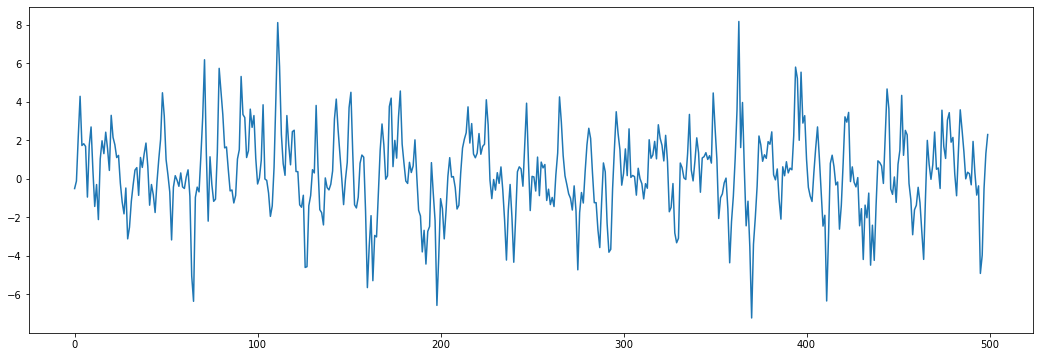

In [4]:
plt.figure(figsize=(18,6))
plt.plot(a)

# EM Algorithm

In [5]:
def outer(x):
    '''
    calculate outer product of a vector x with itself
    '''
    return np.outer(x,x)

In [6]:
def em_algorithm(a, max_iter, tol):
    '''
    run em algorithm for max_iter iterations or until convergence
    '''
    
    npdf = stats.norm.pdf
    
    converged = False
    
    while not converged:
        try:
            # random initial guess
            ksi = np.random.uniform(-3,3,(3))
            zeta_1 = np.random.uniform(-3,3,(3))
            zeta_2 = np.random.uniform(-3,3,(2))
            var_1 = np.random.uniform(0,6,(1))
            var_2 = np.random.uniform(0,6,(1))

            # create dataframe
            df = pd.DataFrame(columns=['const', 'a', 'a_l1', 'a_l2', 'abs_l1', 'abs_l2', 'p1', 'p2', 
                                       'tau1', 'tau2', 'e1', 'e2'])
            df['a'] = a[2:]
            df['a_l1'] = a[1:-1]
            df['a_l2'] = a[:-2]
            df['abs_l1'] = abs(df['a_l1'])
            df['abs_l2'] = abs(df['a_l2'])
            df['const'] = 1


            for s in range(max_iter):
                # E-step
                # solve for mixing probabilities
                num = np.exp((df[['const', 'abs_l1', 'abs_l2']] * ksi).sum(axis=1))
                denom = (1 + np.exp((df[['const', 'abs_l1', 'abs_l2']] * ksi).sum(axis=1)))
                df['p1'] = num/denom
                df['p2'] = 1 - df['p1']

                # calculate e
                df['e1'] = df['a'] - (zeta_1 * df[['const', 'a_l1', 'a_l2']]).sum(axis=1)
                df['e2'] = df['a'] - (zeta_2 * df[['const', 'a_l1']]).sum(axis=1)

                # calculate tau
                sigma_1 = np.sqrt(var_1)
                sigma_2 = np.sqrt(var_2)
                denom = ((df['p1'] / sigma_1) * stats.norm.pdf(df['e1'] / sigma_1) + 
                         (df['p2'] / sigma_2) * stats.norm.pdf(df['e2'] / sigma_2))
                df['tau1'] = (df['p1'] / sigma_1) * stats.norm.pdf(df['e1'] / sigma_1) / denom
                df['tau2'] = (df['p2'] / sigma_2) * stats.norm.pdf(df['e2'] / sigma_2) / denom


                # M-step

                # compute ksi
                dr_dksi = df[['const', 'abs_l1', 'abs_l2']]
                dQ_dksi = (np.tile((df['tau1'] - df['p1']), (3,1)).T * dr_dksi).sum().values
                df['dr_dksi^2'] = df[['const', 'abs_l1', 'abs_l2']].apply(outer, axis=1).apply(np.array)
                d2Q_dksi2 = -(df['p1'] * df['p2'] * df['dr_dksi^2']).sum()
                new_ksi = ksi - np.linalg.inv(d2Q_dksi2) @ dQ_dksi

                # compute zeta
                df['de1_dzeta1^2'] = df[['const', 'a_l1', 'a_l2']].apply(outer, axis=1).apply(np.array)
                df['de2_dzeta2^2'] = df[['const', 'a_l1']].apply(outer, axis=1).apply(np.array)
                zeta1_sum1 = (df['tau1'] * df['de1_dzeta1^2']).sum()
                zeta2_sum1 = (df['tau2'] * df['de2_dzeta2^2']).sum()
                zeta1_sum2 = (-np.tile(df['tau1'] * df['a'], (3,1)).T * -df[['const', 'a_l1', 'a_l2']]).sum().values
                zeta2_sum2 = (-np.tile(df['tau2'] * df['a'], (2,1)).T * -df[['const', 'a_l1']]).sum().values
                new_zeta_1 = np.linalg.inv(zeta1_sum1) @ zeta1_sum2
                new_zeta_2 = np.linalg.inv(zeta2_sum1) @ zeta2_sum2

                # compute variance
                sigma1_sum2 = (df['tau1'] * (df['a'] + np.dot(-df[['const', 'a_l1', 'a_l2']], new_zeta_1))**2).sum()
                sigma2_sum2 = (df['tau2'] * (df['a'] + np.dot(-df[['const', 'a_l1']], new_zeta_2))**2).sum()
                new_var_1 = 1/df['tau1'].sum() * sigma1_sum2
                new_var_2 = 1/df['tau2'].sum() * sigma2_sum2

                # calculate the difference between old and new values of parameters
                delta_ksi = np.sum(abs(new_ksi - ksi))
                delta_zeta_1 = np.sum(abs(new_zeta_1 - zeta_1))
                delta_zeta_2 = np.sum(abs(new_zeta_2 - zeta_2))
                delta_var_1 = np.sum(abs(new_var_1 - var_1))
                delta_var_2 = np.sum(abs(new_var_2 - var_2))

                # update parameters
                ksi = new_ksi
                zeta_1 = new_zeta_1
                zeta_2 = new_zeta_2
                var_1 = new_var_1
                var_2 = new_var_2

                # calculate total difference between old and new parameters
                delta_total = delta_ksi + delta_zeta_1 + delta_zeta_2 + delta_var_1 + delta_var_2

                # check convergence
                if delta_total < tol:
                    # convergence conditions
                    conv_cond = zeta_2[1] >= 1 # second regime is non-stationary
                    if conv_cond:
                        print('Converged at iteration ', s)
                        converged = True
                        break
                    else:
                        break

                # if any parameter is nan, stop
                nansum = (np.isnan(ksi).sum() + np.isnan(zeta_1).sum() + np.isnan(zeta_2).sum() + 
                          np.isnan(var_1).sum() + np.isnan(var_2).sum())
                if nansum != 0:
                    break

            if not converged:
                print(f'Algorithm not converged')
                print('Repeating with different initital values')
        except:
            continue
        
    return ksi, zeta_1, var_1, zeta_2, var_2

In [7]:
delta_0s = []
delta_1s = []
delta_2s = []
phi_10s = []
phi_11s = []
phi_12s = []
phi_20s = []
phi_21s = []
var_1s = []
var_2s = []

max_iter=50
tol = 0.05

N = 1000 # number of datapoints to generate
N_sim = 100 # number of simulations to run

# parameters used to generate a
ksi = [-1.3, 0.6, 0.3]
zeta_1 = [0, 0.6, -0.2]
var_1 = 1
zeta_2 = [0, 1.5]
var_2 = 3

for s in range(N_sim):
    print()
    print('Running sim ', s)
    
    # generate a
    np.random.seed(123+s)
    a = generate_a(N, ksi, zeta_1, var_1, zeta_2, var_2)
    
    # run EM algorithm
    ksi_hat, zeta_1_hat, var_1_hat, zeta_2_hat, var_2_hat = em_algorithm(a, max_iter, tol)
    
    # save results
    delta_0s.append(ksi_hat[0])
    delta_1s.append(ksi_hat[1])
    delta_2s.append(ksi_hat[2])
    phi_10s.append(zeta_1_hat[0])
    phi_11s.append(zeta_1_hat[1])
    phi_12s.append(zeta_1_hat[2])
    phi_20s.append(zeta_2_hat[0])
    phi_21s.append(zeta_2_hat[1])
    var_1s.append(var_1_hat)
    var_2s.append(var_2_hat)


Running sim  0


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  28

Running sim  1
Converged at iteration  24

Running sim  2
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
R

/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  30

Running sim  6
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Converged at iteration  17

Running sim  7
Converged at iteration  17

Running sim  8
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  33

Running sim  9


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Converged at iteration  49

Running sim  10
Converged at iteration  31

Running sim  11
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  11

Running sim  12


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  20

Running sim  13
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  28

Running sim  14
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  24

Running sim  15
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  8

Running sim  16
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  19

Running sim  17
Converged at iteration  10

Running sim  18
Algorithm not converged
Repeating with different initital values
A

/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  16

Running sim  23
Converged at iteration  45

Running sim  24
Converged at iteration  35

Running sim  25
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Converged at iteration  38

Running sim  26
Converged at iteration  27

Running sim  27


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Converged at iteration  21

Running sim  28
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  31

Running sim  29


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Converged at iteration  31

Running sim  30
Converged at iteration  30

Running sim  31


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  38

Running sim  32
Algorithm not converged
Repeating with different initital values
Converged at iteration  41

Running sim  33
Converged at iteration  48

Running sim  34
Converged at iteration  16

Running sim  35
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  15

Running sim  36
Algorithm not converged
Repeating with different initital values
Converged at iteration  46

Running sim  37
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  34

Running sim  38
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  39

Running sim  39
Algorithm not converged
Repeating with different initital values
Al

/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Converged at iteration  31

Running sim  53
Converged at iteration  26

Running sim  54
Algorithm not converged
Repeating with different initital values
Converged at iteration  41

Running sim  55
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Converged at iteration  23

Running sim  56


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  33

Running sim  57


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  25

Running sim  58
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  26

Running sim  59


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Converged at iteration  30

Running sim  60


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Converged at iteration  17

Running sim  61
Algorithm not converged
Repeating with different initital values
Converged at iteration  13

Running sim  62
Algorithm not converged
Repeating with different initital values
Converged at iteration  14

Running sim  63


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  38

Running sim  64
Algorithm not converged
Repeating with different initital values
Converged at iteration  47

Running sim  65
Algorithm not converged
Repeating with different initital values
Converged at iteration  39

Running sim  66
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Converged at iteration  36

Running sim  67
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  43

Running sim  68
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  18

Running sim  69
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  31

Running sim  70
Converged at iteration  42

Running sim  71
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  10

Running sim  72
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with differe

/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  38

Running sim  74
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  38

Running sim  75
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  36

Running sim  76
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  14

Running sim  77
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  16

Running sim  78
Converged at iteration  26

Running sim  79
Converged at iteration  44

Running sim  80
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Converged at iteration  28

Running sim  81
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  15

Running sim  82
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Converged at iteration  16

Running sim  83
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  34

Running sim  84
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  46

Running sim  85
Converged at iteration  10

Running sim  86
Converged at iteration  43

Running sim  87


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Converged at iteration  15

Running sim  94
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
R

/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  34

Running sim  95
Algorithm not converged
Repeating with different initital values
Converged at iteration  43

Running sim  96
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  17

Running sim  97
Converged at iteration  13

Running sim  98
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  33

Running sim  99
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


In [8]:
res = pd.DataFrame.from_dict({r'$\sigma_1^2$':var_1s, r'$\phi_{1,0}$':phi_10s, r'$\phi_{1,1}$':phi_11s, 
                        r'$\phi_{1,2}$':phi_12s, r'$\sigma_2^2$':var_2s, r'$\phi_{2,0}$':phi_20s, 
                        r'$\phi_{2,1}$':phi_21s, r'$\delta_0$':delta_0s, r'$\delta_1$':delta_1s, 
                        r'$\delta_2$':delta_2s})

In [9]:
res.head(5)

,$\sigma_1^2$,"$\phi_{1,0}$","$\phi_{1,1}$","$\phi_{1,2}$",$\sigma_2^2$,"$\phi_{2,0}$","$\phi_{2,1}$",$\delta_0$,$\delta_1$,$\delta_2$
0,0.894221,-0.019048,0.577595,-0.185419,2.707574,-0.207625,1.590736,-1.392787,0.653440,0.314996
1,0.965440,0.050168,0.584820,-0.223871,3.143177,0.006323,1.484688,-1.090314,0.634214,0.320480
2,1.068524,-0.004078,0.579087,-0.204501,2.940133,0.068320,1.496375,-1.072032,0.580037,0.238617
3,0.961893,0.021295,0.575999,-0.148828,2.720907,-0.073152,1.469632,-1.445670,0.606285,0.339199
4,0.905894,-0.163154,0.586048,-0.199668,3.280227,0.010195,1.428144,-1.950154,0.700772,0.359498


In [10]:
pd.DataFrame(res.mean()).T

,$\sigma_1^2$,"$\phi_{1,0}$","$\phi_{1,1}$","$\phi_{1,2}$",$\sigma_2^2$,"$\phi_{2,0}$","$\phi_{2,1}$",$\delta_0$,$\delta_1$,$\delta_2$
0,1.062045,0.001032,0.604038,-0.196105,2.940641,-0.005328,1.479187,-1.722063,1.497534,0.533087


In [11]:
pd.DataFrame(res.std()).T

,$\sigma_1^2$,"$\phi_{1,0}$","$\phi_{1,1}$","$\phi_{1,2}$",$\sigma_2^2$,"$\phi_{2,0}$","$\phi_{2,1}$",$\delta_0$,$\delta_1$,$\delta_2$
0,0.381689,0.064487,0.044192,0.026028,0.389203,0.101297,0.118633,2.558627,5.641816,1.905792


In [13]:
res.describe()

,$\sigma_1^2$,"$\phi_{1,0}$","$\phi_{1,1}$","$\phi_{1,2}$",$\sigma_2^2$,"$\phi_{2,0}$","$\phi_{2,1}$",$\delta_0$,$\delta_1$,$\delta_2$
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.062045,0.001032,0.604038,-0.196105,2.940641,-0.005328,1.479187,-1.722063,1.497534,0.533087
std,0.381689,0.064487,0.044192,0.026028,0.389203,0.101297,0.118633,2.558627,5.641816,1.905792
min,0.652769,-0.163154,0.543313,-0.260744,0.005133,-0.370878,1.151861,-20.961640,0.280673,-0.973211
25%,0.918361,-0.042646,0.578895,-0.210842,2.810590,-0.054512,1.424586,-1.626328,0.559556,0.231274
50%,0.993479,0.002837,0.597609,-0.199454,2.940683,-0.010071,1.483769,-1.339830,0.628430,0.298502
75%,1.068892,0.047261,0.616779,-0.180328,3.171634,0.050386,1.555870,-1.130637,0.717860,0.347236
max,3.026059,0.155552,0.797314,-0.138728,3.647432,0.210560,1.784993,-0.291053,48.722239,15.911444


In [17]:
pd.DataFrame(res.median()).T

,$\sigma_1^2$,"$\phi_{1,0}$","$\phi_{1,1}$","$\phi_{1,2}$",$\sigma_2^2$,"$\phi_{2,0}$","$\phi_{2,1}$",$\delta_0$,$\delta_1$,$\delta_2$
0,0.993479,0.002837,0.597609,-0.199454,2.940683,-0.010071,1.483769,-1.33983,0.62843,0.298502


# EM algorithm for a general case of LMAR(m1,m2,n) model

In [18]:
def em_algorithm(a, m1, m2, n, max_iter, tol):
    '''
    run em algorithm for max_iter iterations or until convergence
    
    a: time series
    m1: order of the first (stationary) AR model
    m2: order of the second (non-stationary) AR model
    n: number of lags in logistic equation
    '''
    
    npdf = stats.norm.pdf
    
    max_lag = max(m1,m2,n)
    
    converged = False
    
    while not converged:
        #try:
        # random initial guess
        ksi = np.random.uniform(-3,3,(n+1))
        zeta_1 = np.random.uniform(-3,3,(m1+1))
        zeta_2 = np.random.uniform(-3,3,(m2+1))
        var_1 = np.random.uniform(0,6,(1))
        var_2 = np.random.uniform(0,6,(1))

        # create dataframe
        a_lags = [f'a_l{i}' for i in range(1,max_lag+1)]
        abs_lags = [f'abs_l{i}' for i in range(1,n+1)]
        columns = ['const', 'a'] + a_lags + abs_lags + ['p1', 'p2', 'tau1', 'tau2', 'e1', 'e2']
        df = pd.DataFrame(columns=columns)
        df['a'] = a[max_lag:]
        df['const'] = 1
        for l in range(1,max_lag+1):
            df[a_lags[l-1]] = a[max_lag-l:-l]
        for l in range(1,n+1):
            df[abs_lags[l-1]] = abs(df[a_lags[l-1]])


        for s in range(max_iter):
            # E-step
            # solve for mixing probabilities
            num = np.exp((df[['const'] + abs_lags] * ksi).sum(axis=1))
            denom = (1 + np.exp((df[['const'] + abs_lags] * ksi).sum(axis=1)))
            df['p1'] = num/denom
            df['p2'] = 1 - df['p1']

            # calculate e
            df['e1'] = df['a'] - (zeta_1 * df[['const'] + a_lags[:m1]]).sum(axis=1)
            df['e2'] = df['a'] - (zeta_2 * df[['const'] + a_lags[:m2]]).sum(axis=1)

            # calculate tau
            sigma_1 = np.sqrt(var_1)
            sigma_2 = np.sqrt(var_2)
            denom = ((df['p1'] / sigma_1) * stats.norm.pdf(df['e1'] / sigma_1) + 
                     (df['p2'] / sigma_2) * stats.norm.pdf(df['e2'] / sigma_2))
            df['tau1'] = (df['p1'] / sigma_1) * stats.norm.pdf(df['e1'] / sigma_1) / denom
            df['tau2'] = (df['p2'] / sigma_2) * stats.norm.pdf(df['e2'] / sigma_2) / denom


            # M-step

            # compute ksi
            dr_dksi = df[['const'] + abs_lags]
            dQ_dksi = (np.tile((df['tau1'] - df['p1']), (n+1,1)).T * dr_dksi).sum().values
            df['dr_dksi^2'] = df[['const'] + abs_lags].apply(outer, axis=1).apply(np.array)
            d2Q_dksi2 = -(df['p1'] * df['p2'] * df['dr_dksi^2']).sum()
            new_ksi = ksi - np.linalg.inv(d2Q_dksi2) @ dQ_dksi

            # compute zeta
            df['de1_dzeta1^2'] = df[['const'] + a_lags[:m1]].apply(outer, axis=1).apply(np.array)
            df['de2_dzeta2^2'] = df[['const'] + a_lags[:m2]].apply(outer, axis=1).apply(np.array)
            zeta1_sum1 = (df['tau1'] * df['de1_dzeta1^2']).sum()
            zeta2_sum1 = (df['tau2'] * df['de2_dzeta2^2']).sum()
            zeta1_sum2 = (-np.tile(df['tau1'] * df['a'], (m1+1,1)).T * -df[['const'] + a_lags[:m1]]).sum().values
            zeta2_sum2 = (-np.tile(df['tau2'] * df['a'], (m2+1,1)).T * -df[['const'] + a_lags[:m2]]).sum().values
            new_zeta_1 = np.linalg.inv(zeta1_sum1) @ zeta1_sum2
            new_zeta_2 = np.linalg.inv(zeta2_sum1) @ zeta2_sum2

            # compute variance
            sigma1_sum2 = (df['tau1'] * (df['a'] + np.dot(-df[['const'] + a_lags[:m1]], new_zeta_1))**2).sum()
            sigma2_sum2 = (df['tau2'] * (df['a'] + np.dot(-df[['const'] + a_lags[:m2]], new_zeta_2))**2).sum()
            new_var_1 = 1/df['tau1'].sum() * sigma1_sum2
            new_var_2 = 1/df['tau2'].sum() * sigma2_sum2

            # calculate the difference between old and new values of parameters
            delta_ksi = np.sum(abs(new_ksi - ksi))
            delta_zeta_1 = np.sum(abs(new_zeta_1 - zeta_1))
            delta_zeta_2 = np.sum(abs(new_zeta_2 - zeta_2))
            delta_var_1 = np.sum(abs(new_var_1 - var_1))
            delta_var_2 = np.sum(abs(new_var_2 - var_2))

            # update parameters
            ksi = new_ksi
            zeta_1 = new_zeta_1
            zeta_2 = new_zeta_2
            var_1 = new_var_1
            var_2 = new_var_2

            # if any parameter is nan, stop
            nansum = (np.isnan(ksi).sum() + np.isnan(zeta_1).sum() + np.isnan(zeta_2).sum() + 
                      np.isnan(var_1).sum() + np.isnan(var_2).sum())
            if nansum != 0:
                break

            # calculate total difference between old and new parameters
            delta_total = delta_ksi + delta_zeta_1 + delta_zeta_2 + delta_var_1 + delta_var_2

            # check convergence
            if delta_total < tol:
                # calculate roots of characteristic polynomial of the second regime
                char_pol = np.polynomial.polynomial.Polynomial(np.concatenate(([1],-zeta_2[1:])))
                # calculate reciprocal roots and take absolute value
                roots = np.abs(1/char_pol.roots())

                # convergence conditions
                # second regime is non-stationary
                conv_cond = sum(roots>=1) > 0 # at least one reciprocal root >= 1

                if conv_cond:
                    print('Converged at iteration ', s)
                    converged = True
                    break
                else:
                    break

        if not converged:
            print(f'Algorithm not converged')
            print('Repeating with different initital values')
        #except:
        #    continue
        
    return ksi, zeta_1, var_1, zeta_2, var_2

In [19]:
delta_0s = []
delta_1s = []
delta_2s = []
phi_10s = []
phi_11s = []
phi_12s = []
phi_20s = []
phi_21s = []
var_1s = []
var_2s = []

max_iter=50
tol = 0.05

N = 1000 # number of datapoints to generate
N_sim = 10 # number of simulations to run

# assume the order of the model is known
m1 = 2
m2 = 1
n = 2

# parameters used to generate a
ksi = [-1.3, 0.6, 0.3]
zeta_1 = [0, 0.6, -0.2]
var_1 = 1
zeta_2 = [0, 1.5]
var_2 = 3

for s in range(N_sim):
    print()
    print('Running sim ', s)
    
    # generate a
    np.random.seed(123+s)
    a = generate_a(N, ksi, zeta_1, var_1, zeta_2, var_2)
    
    # run EM algorithm
    ksi_hat, zeta_1_hat, var_1_hat, zeta_2_hat, var_2_hat = em_algorithm(a, m1, m2, n, max_iter, tol)
    
    # save results
    delta_0s.append(ksi_hat[0])
    delta_1s.append(ksi_hat[1])
    delta_2s.append(ksi_hat[2])
    phi_10s.append(zeta_1_hat[0])
    phi_11s.append(zeta_1_hat[1])
    phi_12s.append(zeta_1_hat[2])
    phi_20s.append(zeta_2_hat[0])
    phi_21s.append(zeta_2_hat[1])
    var_1s.append(var_1_hat)
    var_2s.append(var_2_hat)


Running sim  0


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  28

Running sim  1
Converged at iteration  24

Running sim  2
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
R

/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  30

Running sim  6
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  24

Running sim  7
Converged at iteration  17

Running sim  8
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  33

/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Algorithm not converged
Repeating with different initital values
Converged at iteration  49


In [20]:
res = pd.DataFrame.from_dict({r'$\sigma_1^2$':var_1s, r'$\phi_{1,0}$':phi_10s, r'$\phi_{1,1}$':phi_11s, 
                        r'$\phi_{1,2}$':phi_12s, r'$\sigma_2^2$':var_2s, r'$\phi_{2,0}$':phi_20s, 
                        r'$\phi_{2,1}$':phi_21s, r'$\delta_0$':delta_0s, r'$\delta_1$':delta_1s, 
                        r'$\delta_2$':delta_2s})

In [21]:
res.describe()

,$\sigma_1^2$,"$\phi_{1,0}$","$\phi_{1,1}$","$\phi_{1,2}$",$\sigma_2^2$,"$\phi_{2,0}$","$\phi_{2,1}$",$\delta_0$,$\delta_1$,$\delta_2$
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.125074,-0.023144,0.620569,-0.199713,2.657217,0.307646,1.105197,-0.940240,0.804132,0.290207
std,0.555737,0.068501,0.071861,0.021865,0.955070,1.034000,1.157046,1.688079,0.464359,0.084422
min,0.652769,-0.163154,0.575999,-0.228265,0.000118,-0.207625,-2.180527,-2.286513,0.580037,0.069089
25%,0.914872,-0.045601,0.580520,-0.205329,2.710907,-0.065265,1.413093,-1.732390,0.613267,0.295607
50%,0.963666,-0.001515,0.599962,-0.203253,2.968173,0.008259,1.477160,-1.368767,0.666157,0.317738
75%,1.082901,0.020569,0.623053,-0.195767,3.061246,0.079576,1.513269,-1.076602,0.724699,0.336038
max,2.662819,0.050168,0.816410,-0.148828,3.280227,3.234676,1.590736,3.673539,2.115385,0.359498


In [22]:
pd.DataFrame(res.median()).T

,$\sigma_1^2$,"$\phi_{1,0}$","$\phi_{1,1}$","$\phi_{1,2}$",$\sigma_2^2$,"$\phi_{2,0}$","$\phi_{2,1}$",$\delta_0$,$\delta_1$,$\delta_2$
0,0.963666,-0.001515,0.599962,-0.203253,2.968173,0.008259,1.47716,-1.368767,0.666157,0.317738


# Model selection based on BIC

In [25]:
def em_algorithm(a, m1, m2, n, max_iter, tol):
    '''
    run em algorithm for max_iter iterations or until convergence
    
    a: time series
    m1: order of the first (stationary) AR model
    m2: order of the second (non-stationary) AR model
    n: number of lags in logistic equation
    '''
    
    npdf = stats.norm.pdf
    
    max_lag = max(m1,m2,n)
    
    converged = False
    
    while not converged:
        #try:
        # random initial guess
        ksi = np.random.uniform(-3,3,(n+1))
        zeta_1 = np.random.uniform(-3,3,(m1+1))
        zeta_2 = np.random.uniform(-3,3,(m2+1))
        var_1 = np.random.uniform(0,6,(1))
        var_2 = np.random.uniform(0,6,(1))

        # create dataframe
        a_lags = [f'a_l{i}' for i in range(1,max_lag+1)]
        abs_lags = [f'abs_l{i}' for i in range(1,n+1)]
        columns = ['const', 'a'] + a_lags + abs_lags + ['p1', 'p2', 'tau1', 'tau2', 'e1', 'e2']
        df = pd.DataFrame(columns=columns)
        df['a'] = a[max_lag:]
        df['const'] = 1
        for l in range(1,max_lag+1):
            df[a_lags[l-1]] = a[max_lag-l:-l]
        for l in range(1,n+1):
            df[abs_lags[l-1]] = abs(df[a_lags[l-1]])


        for s in range(max_iter):
            # E-step
            # solve for mixing probabilities
            num = np.exp((df[['const'] + abs_lags] * ksi).sum(axis=1))
            denom = (1 + np.exp((df[['const'] + abs_lags] * ksi).sum(axis=1)))
            df['p1'] = num/denom
            df['p2'] = 1 - df['p1']

            # calculate e
            df['e1'] = df['a'] - (zeta_1 * df[['const'] + a_lags[:m1]]).sum(axis=1)
            df['e2'] = df['a'] - (zeta_2 * df[['const'] + a_lags[:m2]]).sum(axis=1)

            # calculate tau
            sigma_1 = np.sqrt(var_1)
            sigma_2 = np.sqrt(var_2)
            denom = ((df['p1'] / sigma_1) * stats.norm.pdf(df['e1'] / sigma_1) + 
                     (df['p2'] / sigma_2) * stats.norm.pdf(df['e2'] / sigma_2))
            df['tau1'] = (df['p1'] / sigma_1) * stats.norm.pdf(df['e1'] / sigma_1) / denom
            df['tau2'] = (df['p2'] / sigma_2) * stats.norm.pdf(df['e2'] / sigma_2) / denom


            # M-step

            # compute ksi
            dr_dksi = df[['const'] + abs_lags]
            dQ_dksi = (np.tile((df['tau1'] - df['p1']), (n+1,1)).T * dr_dksi).sum().values
            df['dr_dksi^2'] = df[['const'] + abs_lags].apply(outer, axis=1).apply(np.array)
            d2Q_dksi2 = -(df['p1'] * df['p2'] * df['dr_dksi^2']).sum()
            new_ksi = ksi - np.linalg.inv(d2Q_dksi2) @ dQ_dksi

            # compute zeta
            df['de1_dzeta1^2'] = df[['const'] + a_lags[:m1]].apply(outer, axis=1).apply(np.array)
            df['de2_dzeta2^2'] = df[['const'] + a_lags[:m2]].apply(outer, axis=1).apply(np.array)
            zeta1_sum1 = (df['tau1'] * df['de1_dzeta1^2']).sum()
            zeta2_sum1 = (df['tau2'] * df['de2_dzeta2^2']).sum()
            zeta1_sum2 = (-np.tile(df['tau1'] * df['a'], (m1+1,1)).T * -df[['const'] + a_lags[:m1]]).sum().values
            zeta2_sum2 = (-np.tile(df['tau2'] * df['a'], (m2+1,1)).T * -df[['const'] + a_lags[:m2]]).sum().values
            new_zeta_1 = np.linalg.inv(zeta1_sum1) @ zeta1_sum2
            new_zeta_2 = np.linalg.inv(zeta2_sum1) @ zeta2_sum2

            # compute variance
            sigma1_sum2 = (df['tau1'] * (df['a'] + np.dot(-df[['const'] + a_lags[:m1]], new_zeta_1))**2).sum()
            sigma2_sum2 = (df['tau2'] * (df['a'] + np.dot(-df[['const'] + a_lags[:m2]], new_zeta_2))**2).sum()
            new_var_1 = 1/df['tau1'].sum() * sigma1_sum2
            new_var_2 = 1/df['tau2'].sum() * sigma2_sum2

            # calculate the difference between old and new values of parameters
            delta_ksi = np.sum(abs(new_ksi - ksi))
            delta_zeta_1 = np.sum(abs(new_zeta_1 - zeta_1))
            delta_zeta_2 = np.sum(abs(new_zeta_2 - zeta_2))
            delta_var_1 = np.sum(abs(new_var_1 - var_1))
            delta_var_2 = np.sum(abs(new_var_2 - var_2))

            # update parameters
            ksi = new_ksi
            zeta_1 = new_zeta_1
            zeta_2 = new_zeta_2
            var_1 = new_var_1
            var_2 = new_var_2

            # if any parameter is nan, stop
            nansum = (np.isnan(ksi).sum() + np.isnan(zeta_1).sum() + np.isnan(zeta_2).sum() + 
                      np.isnan(var_1).sum() + np.isnan(var_2).sum())
            if nansum != 0:
                break

            # calculate total difference between old and new parameters
            delta_total = delta_ksi + delta_zeta_1 + delta_zeta_2 + delta_var_1 + delta_var_2

            # check convergence
            if delta_total < tol:
                # calculate roots of characteristic polynomial of the second regime
                char_pol = np.polynomial.polynomial.Polynomial(np.concatenate(([1],-zeta_2[1:])))
                # calculate reciprocal roots and take absolute value
                roots = np.abs(1/char_pol.roots())

                # convergence conditions
                # second regime is non-stationary
                conv_cond = sum(roots>=1) > 0 # at least one reciprocal root >= 1

                if conv_cond:
                    print('Converged at iteration ', s)
                    converged = True
                    break
                else:
                    break

        if not converged:
            print(f'Algorithm not converged')
            print('Repeating with different initital values')
        #except:
        #    continue
        
        # calculate Q
        Q_sum1 = (df['tau1'] * (np.log(df['p1']) - 1/2*np.log(var_1) - df['e1']**2 / (2 * var_1))).sum()
        Q_sum2 = (df['tau2'] * (np.log(df['p2']) - 1/2*np.log(var_2) - df['e2']**2 / (2 * var_2))).sum()
        Q = Q_sum1 + Q_sum2
        
    return ksi, zeta_1, var_1, zeta_2, var_2, Q

In [26]:
import warnings
import itertools

bic_df = pd.DataFrame(columns=['m1', 'm2', 'n', 'BIC'])

max_iter=50
tol = 0.05

N = 1000 # number of datapoints to generate
N_sim = 50 # number of simulations to run

# parameters used to generate a
ksi = [-1.3, 0.6, 0.3]
zeta_1 = [0, 0.6, -0.2]
var_1 = 1
zeta_2 = [0, 1.5]
var_2 = 3

for s in range(N_sim):
    print('Running sim ', s)
    
    # generate a
    np.random.seed(123+s)
    a = generate_a(N, ksi, zeta_1, var_1, zeta_2, var_2)
    
    best_bic = np.inf
    best_m1, best_m2, best_n = 0,0,0
    
    for m1,m2,n in itertools.product([1,2],[1,2],[1,2]):
        
        with warnings.catch_warnings():
            warnings.simplefilter('ignore') # supress warnings from EM algorithm
            # run EM algorithm to estimate parameters
            ksi_hat, zeta_1_hat, var_1_hat, zeta_2_hat, var_2_hat, Q = em_algorithm(a, m1, m2, n, max_iter, tol)
        
        # compute bic
        bic = -2*Q + np.log(N - max(m1,m2,n)) * (m1 + m2 + n)
        
        if bic < best_bic:
            best_bic = bic
            best_m1, best_m2, best_n = m1,m2,n
    print(f'm1={best_m1}, m2={best_m2}, n={best_n}, BIC={best_bic}')
    bic_df.loc[s] = best_m1, best_m2, best_n, best_bic
    print()

Running sim  0
Algorithm not converged
Repeating with different initital values
Converged at iteration  23
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  18
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  31
Converged at iteration  43
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Converged at iteration  22
Algorithm not converged
Repeating with different initital values
Algorithm not converged
Repeating with different initital values
Algor

In [27]:
bic_df.head()

,m1,m2,n,BIC
0,1.0,1.0,2.0,2104.875522
1,1.0,2.0,1.0,2183.044499
2,2.0,1.0,2.0,2763.778597
3,2.0,2.0,2.0,2666.080571
4,1.0,1.0,1.0,2457.365570


In [28]:
len(bic_df[bic_df['m1']==2]) / len(bic_df)

0.78

In [29]:
len(bic_df[bic_df['m2']==1]) / len(bic_df)

0.48

In [30]:
len(bic_df[bic_df['n']==2]) / len(bic_df)

0.4

In [31]:
len(bic_df[(bic_df['m1']==2) & (bic_df['m2']==1) & (bic_df['n']==2)]) / len(bic_df)

0.22